# DSCI 525 Web and Cloud Computing 
## Milestone 1 Tackling big data on your laptop 
Authors: Amelia Tang, Chaoran Wang, Junrong Zhu (Group 13) 

### Import Dependencies

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import numpy as np

### Downloading the data
1. Download the data from figshare to local computers using the figshare API and requests library.
2. Extract the zip file

In [2]:
article_id = 14096681  # this is the unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "figshare/"

In [3]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)
files = data["files"]
files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26766812',
  'supplied_md5': 'b517383f76e77bd03755a63a8f

In [4]:
files_to_dl = ["data.zip"]  
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

In [5]:
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

In [6]:
os.remove("figshare/observed_daily_rainfall_SYD.csv")

### Combining data CSVs
1. Combine data CSVs into a single CSV using pandas.
2. When combining the CSV files, add an extra column called "model" that identifies the model. 
3. Compare run times on different machines within our team. 

In [7]:
%%time

use_cols = ["time", "lat_min", "lat_max", "lon_min", "lon_max", "rain (mm/day)"]
files = glob.glob('figshare/*.csv')

df = pd.concat((pd.read_csv(file, index_col=0, usecols=use_cols)
                .assign(model=re.findall(r"/([^_]*)", file)[0])
                for file in files))

df.to_csv("figshare/combined_data.csv")

CPU times: user 5min 15s, sys: 11.7 s, total: 5min 27s
Wall time: 5min 33s


### Time Comparison Table for Combining CSVs


| Team Member  |Operating System|RAM|Processor|Is SSD| Time Taken|
| -------------| -------------- | - | --- ----| -----| --------- |
| Junrong Zhu  |macOS Monterey  |8GB|   CPU - Apple M1 chip 8-core   |  Yes | Total time 5min 57s|
| Amelia Tang  |macOS Monterey  |8GB|   CPU - 2.2 GHz Dual-Core Intel Core i7   |  Yes | Total time 10min 1s|
| Chaoran Wang | macOS Big Sur   | 16GB  | CPU - 4.2 Ghz Quad-Core Intel Core i7 | Yes | Total time 5min 27s |

***Our Observations***
We observed that computers whose CPU had more cores tended to combine the files faster. Besides, the more RAM a computer had, the less time it took to process the files. Given that our operating systems were all MacOS and we all had SSD, we did not observe how different operating systems and whether have SSD affected the speed. However, based on our research, different operating systems do impact the speed so do the specifications of SSDs.  

Sources: https://dash.harvard.edu/bitstream/handle/1/24829608/tr-09-95.pdf
<br>https://ssdsphere.com/how-does-ssd-speed-up-a-system/

### Load the combined CSV to memory and perform a simple EDA

In order to understand our data better, we performed following exploratory data analysis steps:

- observing and changing the `dtype` of the data
- loading the columns of interest
- loading in chunks

We are going to present the EDA in `Python` and `R` respectively.

#### Python: Reading the dataset

In [8]:
df = pd.read_csv("figshare/combined_data.csv", parse_dates=True, index_col='time')

In [9]:
df.shape

(62467843, 6)

#### Python: observing and changing the `dtype` of the data 
We observed the `dtype` for each column. 

In [10]:
df.dtypes

lat_min          float64
lat_max          float64
lon_min          float64
lon_max          float64
rain (mm/day)    float64
model             object
dtype: object

Then, we used `.describe()` to do a simple EDA on the combined dataset with default data types for all the columns and we loaded all the original columns. We timed the process to establish the baseline for comparisons. 

In [11]:
%%time
df.describe() # baseline

CPU times: user 8.94 s, sys: 3.78 s, total: 12.7 s
Wall time: 12.8 s


,lat_min,lat_max,lon_min,lon_max,rain (mm/day)
count,5.924854e+07,6.246784e+07,5.924854e+07,6.246784e+07,5.924854e+07
mean,-3.310482e+01,-3.197757e+01,1.469059e+02,1.482150e+02,1.901170e+00
std,1.963549e+00,1.992067e+00,3.793784e+00,3.809994e+00,5.585735e+00
min,-3.646739e+01,-3.600000e+01,1.406250e+02,1.412500e+02,-3.807373e-12
25%,-3.486911e+01,-3.366221e+01,1.434375e+02,1.450000e+02,3.838413e-06
50%,-3.300000e+01,-3.204188e+01,1.468750e+02,1.481250e+02,6.154947e-02
75%,-3.140170e+01,-3.015707e+01,1.501875e+02,1.513125e+02,1.020918e+00
max,-2.990000e+01,-2.790606e+01,1.537500e+02,1.556250e+02,4.329395e+02


We will then further explore the memory consumption with different `dtype` for the numeric columns, and we assume less memory usage is likely to associated with less running time.

In [12]:
print(f"Memory usage with float64: {df[['lat_min','lat_max','lon_min', 'lon_max', 'rain (mm/day)']].memory_usage().sum() / 1e6:.2f} MB")
print(f"Memory usage with float32: {df[['lat_min','lat_max','lon_min', 'lon_max', 'rain (mm/day)']].astype('float32', errors='ignore').memory_usage().sum() / 1e6:.2f} MB")

Memory usage with float64: 2998.46 MB
Memory usage with float32: 1749.10 MB


We observed that using data type `float32` instead of `float64` would save about half of the memory, so we changed 5 numeric columns from `float64` to `float32` in the code cell below.

In [23]:
# converting dtype
colum_dtypes = {'lat_min': np.float32, 
                'lat_max': np.float32, 
                'lon_min': np.float32, 
                'lon_max': np.float32, 
                'rain (mm/day)': np.float32}

df_new = pd.read_csv("figshare/combined_data.csv", 
                     parse_dates=True, index_col='time', dtype=colum_dtypes)

df_new.head()

,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
time,,,,,,
1889-01-01 12:00:00,-35.439865,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1889-01-02 12:00:00,-35.439865,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
1889-01-03 12:00:00,-35.439865,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
1889-01-04 12:00:00,-35.439865,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
1889-01-05 12:00:00,-35.439865,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


In [14]:
# Check the columns' data type after converting

df_new.dtypes

lat_min          float32
lat_max          float32
lon_min          float32
lon_max          float32
rain (mm/day)    float32
model             object
dtype: object

In [15]:
%%time
df_new.describe() # time comparison

CPU times: user 6.42 s, sys: 1.58 s, total: 8 s
Wall time: 8.06 s


,lat_min,lat_max,lon_min,lon_max,rain (mm/day)
count,5.924854e+07,6.246784e+07,5.924854e+07,6.246784e+07,5.924854e+07
mean,-3.310497e+01,-3.197765e+01,1.469057e+02,1.482150e+02,1.901173e+00
std,1.963549e+00,1.992067e+00,3.793784e+00,3.809994e+00,5.585735e+00
min,-3.646739e+01,-3.600000e+01,1.406250e+02,1.412500e+02,-3.807373e-12
25%,-3.486911e+01,-3.366221e+01,1.434375e+02,1.450000e+02,3.838413e-06
50%,-3.300000e+01,-3.204189e+01,1.468750e+02,1.481250e+02,6.154947e-02
75%,-3.140170e+01,-3.015707e+01,1.501875e+02,1.513125e+02,1.020918e+00
max,-2.990000e+01,-2.790606e+01,1.537500e+02,1.556250e+02,4.329395e+02


#### Python: loading the columns of interest

Since what we were interested in the most was the rainfall in mm/day, we loaded only the `time` and `rain (mm/day)` columns this time. 

In [19]:
df_subset = pd.read_csv("figshare/combined_data.csv",
                        parse_dates=True, index_col='time', 
                        usecols=['time', 'rain (mm/day)'])

df_subset.head()

,rain (mm/day)
time,
1889-01-01 12:00:00,4.244226e-13
1889-01-02 12:00:00,4.217326e-13
1889-01-03 12:00:00,4.498125e-13
1889-01-04 12:00:00,4.251282e-13
1889-01-05 12:00:00,4.270161e-13


In [20]:
%%time
df_subset.describe() # running same EDA step on the subset data

CPU times: user 2.43 s, sys: 819 ms, total: 3.25 s
Wall time: 3.27 s


,rain (mm/day)
count,5.924854e+07
mean,1.901170e+00
std,5.585735e+00
min,-3.807373e-12
25%,3.838413e-06
50%,6.154947e-02
75%,1.020918e+00
max,4.329395e+02


### Comparison table for Python EDA timing

| Team Member  |Operating System|RAM|Processor|Is SSD| Baseline time for EDA | Time after changing `dtype`| Time for fewer columns|
| -------------| -------------- | - | --- ----| -----| --------- |  --------- |  --------- |
| Junrong Zhu  |macOS Monterey  |8GB|   CPU - Apple M1 chip 8-core   |  Yes | Total: 13.5s Wall time: 16s|  Total: 7.35s Wall time: 7.73s |  total: 3.04 s Wall time: 3.24 s
| Amelia Tang  |macOS Monterey  |8GB|   CPU - 2.2 GHz Dual-Core Intel Core i7   |  Yes | Total: 22.4s Wall time: 26.1s| Total: 13.2s Wall time: 15s | total: 4.82 s Wall time: 4.97 s 
| Chaoran Wang | macOS Big Sur   | 16GB | CPU - 4.2 Ghz Quad-Core Intel Core i7 | Yes | Total: 12.7s Wall time: 12.8s| Total: 8s Wall time: 8.06s | total: 3.53 s Wall time: 3.57 s

### Summary for Python 
- Changing `dtype` 
> After changing the `dtype` from `float64` to `float32`, the memory usage decreased by around 50% and we observed obvious decreases in total / wall time to perform the simple EDA across our team member's computers.  
- Loading on the columns needed 
> Since our main focus here was daily rainfall so we are most interested in the `time` and `rain (mm/day)` columns. After extracting the subset of data, we saw significant decreases in total / wall time comparing to both Baseline time and the time from converting `dtype` across our team member's computers. 

### R Section

#### Transfer dataframe from python to R

Since we are just storage the data for short term here, we prefer to use feather file approach. Based on the previous discussion, we choose to just use the subset of data because we are most interested in the `time` and `rain (mm/day)` columns.

In [27]:
df_new = df_new.reset_index()

In [28]:
%%time
df_new.to_feather("figshare/combined_data.feather")

CPU times: user 4.71 s, sys: 980 ms, total: 5.69 s
Wall time: 3.4 s


In [29]:
%%sh
du -sh figshare/subset_combined_data.feather

911M	figshare/subset_combined_data.feather


We can see our feather file of the data is only 911M.

In [30]:
%%time
df_feather = pd.read_feather('figshare/combined_data.feather')
df_feather.head()

CPU times: user 3.84 s, sys: 4.25 s, total: 8.08 s
Wall time: 4.52 s


,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-35.439865,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1,1889-01-02 12:00:00,-35.439865,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
2,1889-01-03 12:00:00,-35.439865,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
3,1889-01-04 12:00:00,-35.439865,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
4,1889-01-05 12:00:00,-35.439865,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


In [31]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [32]:
%%R
suppressMessages(library(arrow))
df_feather <- arrow::read_feather('figshare/combined_data.feather')
head(df_feather)

# A tibble: 6 × 7
  time                lat_min lat_max lon_min lon_max `rain (mm/day)` model     
  <dttm>                <dbl>   <dbl>   <dbl>   <dbl>           <dbl> <chr>     
1 1889-01-01 04:00:00   -35.4   -33.6    142.    143.        4.24e-13 MPI-ESM-1…
2 1889-01-02 04:00:00   -35.4   -33.6    142.    143.        4.22e-13 MPI-ESM-1…
3 1889-01-03 04:00:00   -35.4   -33.6    142.    143.        4.50e-13 MPI-ESM-1…
4 1889-01-04 04:00:00   -35.4   -33.6    142.    143.        4.25e-13 MPI-ESM-1…
5 1889-01-05 04:00:00   -35.4   -33.6    142.    143.        4.27e-13 MPI-ESM-1…
6 1889-01-06 04:00:00   -35.4   -33.6    142.    143.        4.20e-13 MPI-ESM-1…


#### Simple EDA

In [34]:
%%R
summary(df_feather)

      time                        lat_min           lat_max      
 Min.   :1888-12-31 16:00:00   Min.   :-36       Min.   :-36.00  
 1st Qu.:1920-07-02 04:00:00   1st Qu.:-35       1st Qu.:-33.66  
 Median :1952-01-01 04:00:00   Median :-33       Median :-32.04  
 Mean   :1952-01-01 08:32:08   Mean   :-33       Mean   :-31.98  
 3rd Qu.:1983-07-02 05:00:00   3rd Qu.:-31       3rd Qu.:-30.16  
 Max.   :2014-12-31 04:00:00   Max.   :-30       Max.   :-27.91  
                               NA's   :3219300                   
    lon_min           lon_max      rain (mm/day)        model          
 Min.   :141       Min.   :141.2   Min.   :  0       Length:62467843   
 1st Qu.:143       1st Qu.:145.0   1st Qu.:  0       Class :character  
 Median :147       Median :148.1   Median :  0       Mode  :character  
 Mean   :147       Mean   :148.2   Mean   :  2                         
 3rd Qu.:150       3rd Qu.:151.3   3rd Qu.:  1                         
 Max.   :154       Max.   :155.6   Max. 

In [4]:
%%R
df_feather$year <- format(df_feather$time, format = "%Y")
head(df_feather)

                 time rain (mm/day) year
1 1889-01-01 04:00:00  4.244226e-13 1889
2 1889-01-02 04:00:00  4.217326e-13 1889
3 1889-01-03 04:00:00  4.498125e-13 1889
4 1889-01-04 04:00:00  4.251282e-13 1889
5 1889-01-05 04:00:00  4.270161e-13 1889
6 1889-01-06 04:00:00  4.197289e-13 1889


In [7]:
%%R
colnames(df_feather)[7] <- "rain"
df_feather <- aggregate(rain ~ year, data = df_feather, mean)
head(df_feather)

  year       rain
1 1888 0.04849994
2 1889 1.97752881
3 1890 1.94524687
4 1891 1.86589156
5 1892 1.86351236
6 1893 2.07654646


In [17]:
%%R
df_feather$year <- as.numeric(df_feather$year)

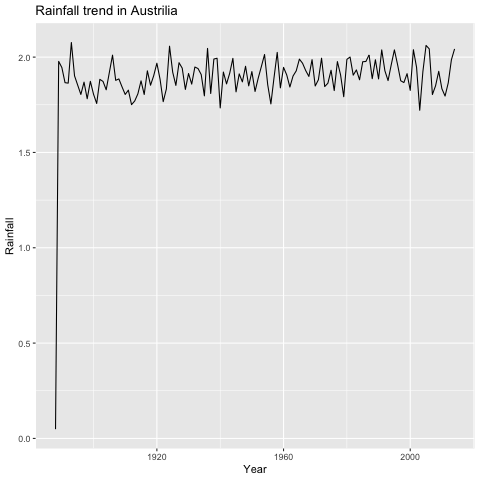

In [18]:
%%R
suppressMessages(library(ggplot2))
ggplot(data = df_feather, aes(x = year, y = rain)) +
  geom_line() +
  labs(title = "Rainfall trend in Austrilia", x = "Year", y = "Rainfall")

## Challenges

1. One of the challenges we had with Q5 was the long running time. For example, we wanted to have a general overview on the dataframe by using `.info()` like what we did in other courses, however, it took a long time to output the dtype for each variable as well as other information which we were not particularly interested in. As an alternative approach, we used `.dtypes` to get the data type of columns and it returned the results immediately.

2. For EDA of R, we are struggling to find a proper analysis because of the big data set. We finally choose to plot a simple line plot to show the trend of rain through years. Due to the large data size, we choose to aggregate it with means of rainfall by years. Aggregate takes about 10 minutes which seems to be acceptable. It seems the rainfall data from the first year has some problems.